In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

def generate_data(total_samples=100_000):
    rock_props = {
    "igneous_rocks": {
        "velocity_km_s": (5.4, 0.3),
        "amplitude": (0.58, 0.05),
        "duration_ms": (230, 20)
    },
    "metamorphic_rocks": {
        "velocity_km_s": (6.3, 0.2),
        "amplitude": (0.72, 0.03),
        "duration_ms": (260, 15)
    },
    "sedimentary_rocks": {
        "velocity_km_s": (2.3, 0.2),
        "amplitude": (0.38, 0.04),
        "duration_ms": (175, 15)
    },
    "ore_and_industrial_minerals": {
        "velocity_km_s": (4.2, 0.3),
        "amplitude": (0.52, 0.05),
        "duration_ms": (235, 20)
    },
    "silicate_minerals": {
        "velocity_km_s": (5.1, 0.2),
        "amplitude": (0.63, 0.04),
        "duration_ms": (290, 20)
    },
    "evaporites_and_soft_minerals": {
        "velocity_km_s": (1.7, 0.15),
        "amplitude": (0.27, 0.02),
        "duration_ms": (145, 10)
    },
    "gem_and_rare_minerals": {
        "velocity_km_s": (6.9, 0.25),
        "amplitude": (0.83, 0.04),
        "duration_ms": (315, 20)
    }
}

    data, labels = [], []
    for label, props in rock_props.items():
        n = total_samples // len(rock_props)
        v = np.random.normal(loc=props['velocity_km_s'][0], scale=props['velocity_km_s'][1], size=n)
        a = np.random.normal(loc=props['amplitude'][0], scale=props['amplitude'][1], size=n)
        d = np.random.normal(loc=props['duration_ms'][0], scale=props['duration_ms'][1], size=n)
        features = np.stack([v, a, d], axis=1)
        features = np.clip(features, [0, 0, 1], None)
        data.append(features)
        labels += [label] * n

    X = np.vstack(data)
    y = np.array(labels)
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

X, y = generate_data()
df = pd.DataFrame(X, columns=["velocity", "amplitude", "duration"])

print(df)

       velocity  amplitude    duration
0      5.224262   0.514664  243.212622
1      6.365580   0.701308  262.641179
2      2.589922   0.368803  198.669506
3      1.975663   0.418771  198.254345
4      4.308533   0.490426  237.754795
...         ...        ...         ...
99990  4.383098   0.475934  220.898565
99991  5.911609   0.438987  233.149031
99992  2.120478   0.342983  199.873695
99993  4.473563   0.531077  219.778814
99994  1.945022   0.407298  151.958633

[99995 rows x 3 columns]


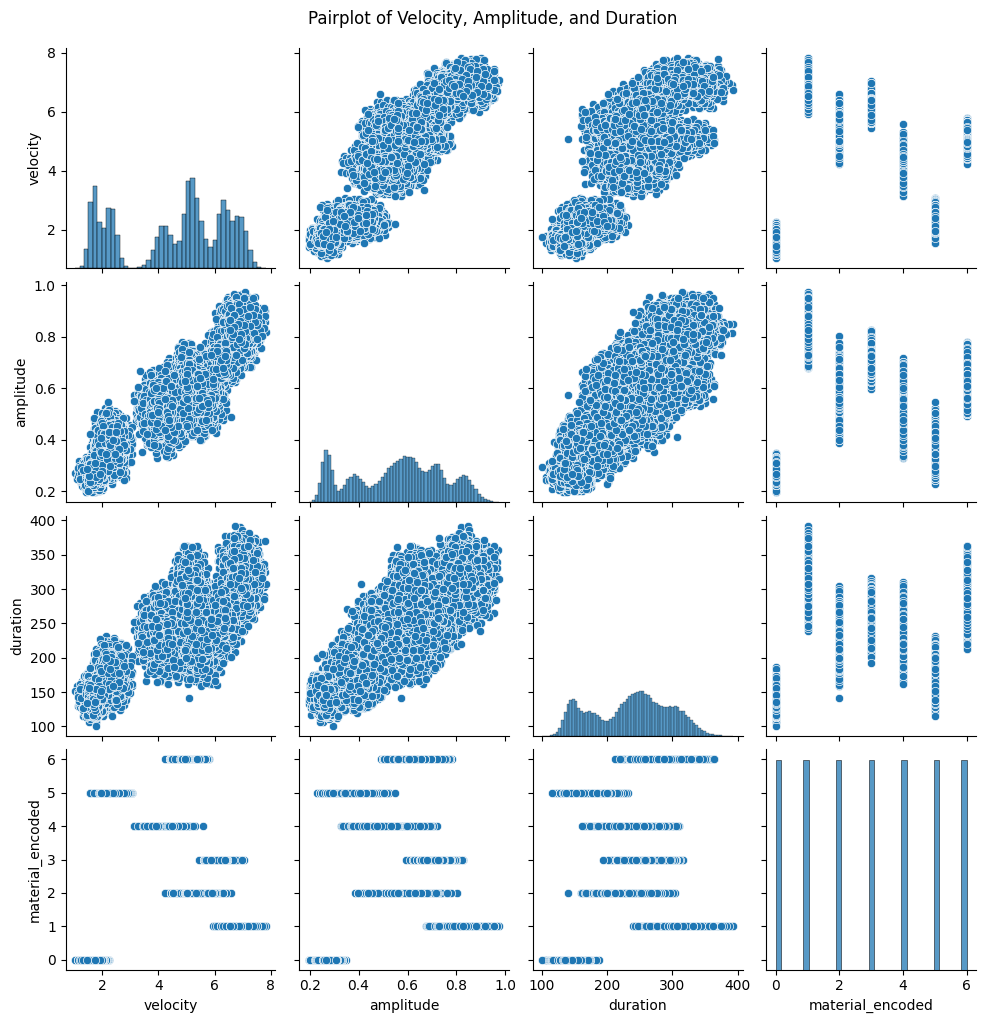

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)
plt.suptitle("Pairplot of Velocity, Amplitude, and Duration", y=1.02)
plt.show()

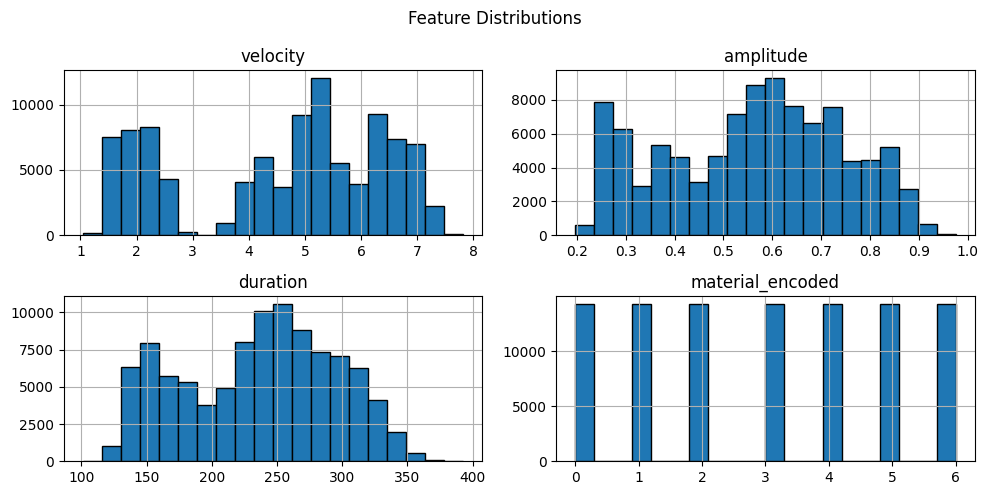

In [12]:
df.hist(bins=20, figsize=(10, 5), edgecolor='black')
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

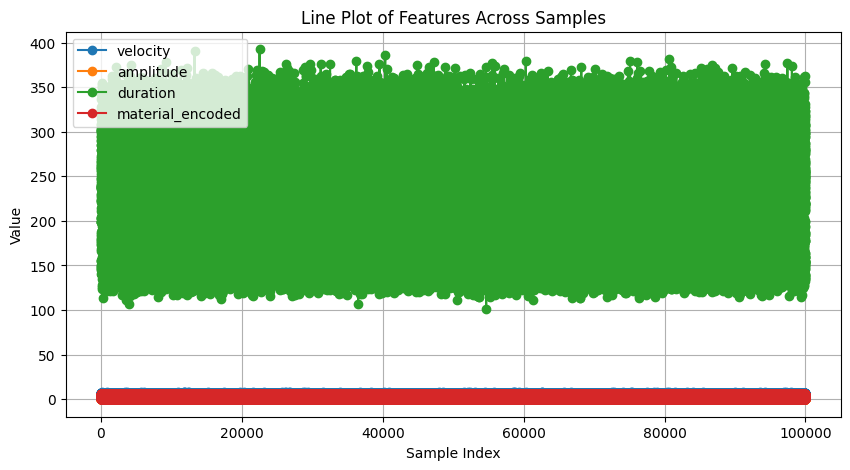

In [15]:
df.plot(figsize=(10, 5), marker='o')
plt.title("Line Plot of Features Across Samples")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [2]:
df['material'] = y

le = LabelEncoder()
df['material_encoded'] = le.fit_transform(df['material'])

X = df[['velocity', 'amplitude', 'duration']].values
y = df['material_encoded'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(3,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079 (43.28 KB)

 Trainable params: 11,079 (43.28 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
2493/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8150 - loss: 0.4721

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8153 - loss: 0.4714 - val_accuracy: 0.9726 - val_loss: 0.0739 - learning_rate: 0.0010
Epoch 2/100
2491/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1067

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9626 - loss: 0.1066 - val_accuracy: 0.9768 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 3/100
2488/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9694 - loss: 0.0913

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9694 - loss: 0.0913 - val_accuracy: 0.9770 - val_loss: 0.0637 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9719 - loss: 0.0838 - val_accuracy: 0.9768 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 5/100
2498/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9734 - loss: 0.0800

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9734 - loss: 0.0800 - val_accuracy: 0.9771 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9741 - loss: 0.0754 - val_accuracy: 0.9769 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9754 - loss: 0.0715 - val_accuracy: 0.9771 - val_loss: 0.0623 - learning_rate: 5.0000e-04
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9750 - loss: 0.0721 - val_accuracy: 0.9765 - val_loss: 0.0636 - learning_rate: 5.0000e-04
Epoch 9/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9760 - loss: 0.0693 - val_accuracy: 0.9765 - val_loss: 0.0630 - learning_rate: 5.0000e-04
Epoch 10/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9760 - loss: 0.0693 - val_accuracy: 0.9769 - val_loss: 0.0615 - learning_rate: 2.5000e-04


In [5]:
print("\n--- Evaluating the Model on Test Data ---")
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


--- Evaluating the Model on Test Data ---
Test Loss: 0.0625
Test Accuracy: 0.9771


In [6]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print("\n--- Sample Predictions ---")
for i in range(10):
    print(f"[{i}] Actual: {y_test_labels[i]} | Predicted: {y_pred_labels[i]}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Sample Predictions ---
[0] Actual: ore_and_industrial_minerals | Predicted: ore_and_industrial_minerals
[1] Actual: silicate_minerals | Predicted: silicate_minerals
[2] Actual: evaporites_and_soft_minerals | Predicted: sedimentary_rocks
[3] Actual: evaporites_and_soft_minerals | Predicted: evaporites_and_soft_minerals
[4] Actual: metamorphic_rocks | Predicted: metamorphic_rocks
[5] Actual: ore_and_industrial_minerals | Predicted: ore_and_industrial_minerals
[6] Actual: ore_and_industrial_minerals | Predicted: ore_and_industrial_minerals
[7] Actual: gem_and_rare_minerals | Predicted: gem_and_rare_minerals
[8] Actual: evaporites_and_soft_minerals | Predicted: evaporites_and_soft_minerals
[9] Actual: evaporites_and_soft_minerals | Predicted: evaporites_and_soft_minerals


In [8]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))


--- Classification Report ---
                              precision    recall  f1-score   support

evaporites_and_soft_minerals       1.00      1.00      1.00      2857
       gem_and_rare_minerals       1.00      0.99      0.99      2857
               igneous_rocks       0.95      0.92      0.93      2857
           metamorphic_rocks       0.99      0.99      0.99      2857
 ore_and_industrial_minerals       0.97      0.98      0.98      2857
           sedimentary_rocks       1.00      1.00      1.00      2857
           silicate_minerals       0.94      0.96      0.95      2857

                    accuracy                           0.98     19999
                   macro avg       0.98      0.98      0.98     19999
                weighted avg       0.98      0.98      0.98     19999



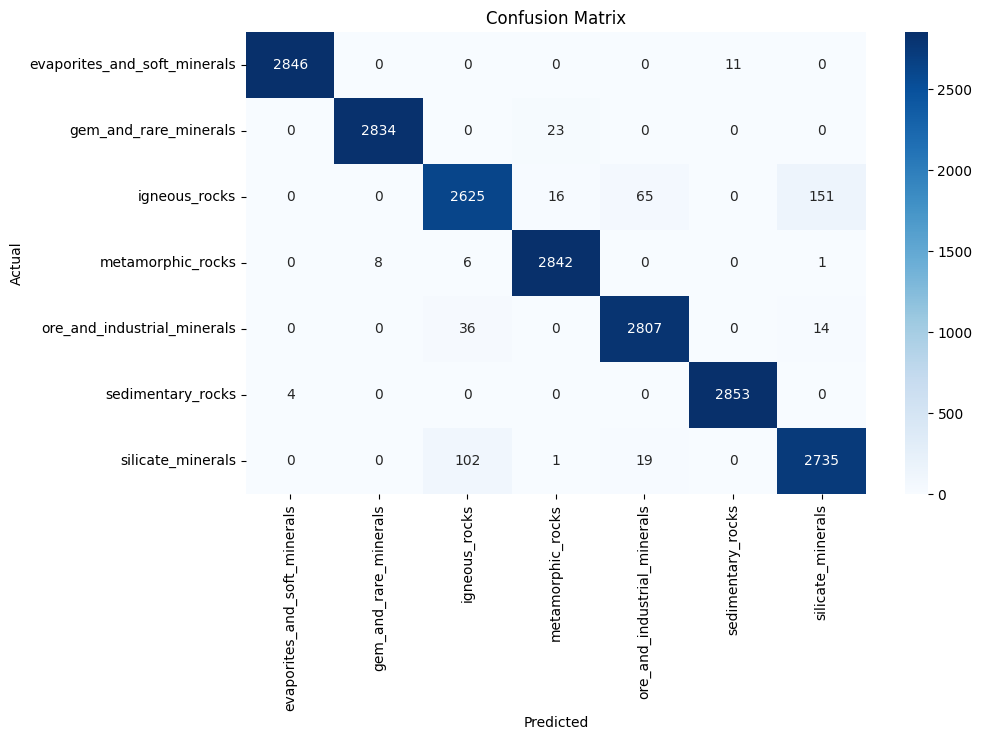

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
sample = np.array([[2.61, 0.32, 175]])
sample_scaled = scaler.transform(sample)
pred = model.predict(sample_scaled)
pred_label = le.inverse_transform([np.argmax(pred)])[0]
print("\nPrediction for sample:", sample.tolist())
print("Predicted class:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Prediction for sample: [[2.61, 0.32, 175.0]]
Predicted class: sedimentary_rocks


In [ ]:
model_h5_path = 'rock-type-prediction-model.h5'
model.save(model_h5_path)
print(f"Model saved to: {model_h5_path}")

Model saved to: rock-type-prediction-model.h5


In [ ]:
model.save('material_type_pred_model.keras')